In [1]:
import gym
import pybulletgym
import numpy as np
import collections
import random
import torch
from torch._C import Size
from torch.distributions import Normal
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

In [2]:
class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self,item):
        self.buffer.append(item)

    def sample(self,n):
        mini_batch = random.sample(self.buffer,n)
        s_list, a_list, r_list, s_prime_list, done_mask_list = [], [], [], [], []

        for item in mini_batch:
            s, a, r, s_prime, done = item
            s_list.append(s)
            a_list.append(a)
            r_list.append([r])
            s_prime_list.append(s_prime)
            done_mask = 0.0 if done else 1.0 
            done_mask_list.append([done_mask])
        s_list = torch.tensor(s_list, dtype = torch.float)
        a_list = torch.tensor(a_list, dtype = torch.float)
        r_list = torch.tensor(r_list, dtype = torch.float)
        s_prime_list = torch.tensor(s_prime_list, dtype = torch.float)
        done_mask_list = torch.tensor(done_mask_list, dtype = torch.float)
        return s_list, a_list, r_list, s_prime_list, done_mask_list

    def size(self):
        return len(self.buffer)

In [3]:
class Actor(nn.Module):
    def __init__(self, learning_rate):
        super(Actor,self).__init__()
        # Gaussian Distribution 이용할 것
        self.fc1 = nn.Linear(28,256)
        self.fc2 = nn.Linear(256,256)
        self.fc_mean = nn.Linear(256,8)
        self.fc_std = nn.Linear(256,8)
        self.optimizer = optim.Adam(self.parameters(),lr=learning_rate)

        # Autotuning Alpha
        self.log_alpha = torch.tensor(np.log(init_alpha))
        self.log_alpha.requires_grad = True
        self.log_alpha_optimizer = optim.Adam([self.log_alpha],lr = lr_alpha)  

    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc_mean(x)
        # std는 정의상 양수가 되어야하므로 softplus나 ReLU같은 activate function 활용
        std = F.softplus(self.fc_std(x))
        Gaussian = Normal(mean,std)
        action = Gaussian.rsample()
        log_prob = Gaussian.log_prob(action)
        # action을 -1 ~ 1 사이의 torque로 만들기 위한 과정
        real_action = torch.tanh(action)
        real_log_prob = log_prob - torch.log(1-torch.tanh(action).pow(2) + 1e-7)
        return real_action, real_log_prob

    def train_p(self,q1,q2,mini_batch):
        s, _, _, _, _ = mini_batch
        a, log_prob = self.forward(s)
        entropy = -self.log_alpha.exp() * log_prob

        q1_val, q2_val = q1(s,a), q2(s,a)
        q1_q2 = torch.cat([q1_val, q2_val], dim=1)
        min_q = torch.min(q1_q2, 1, keepdim=True)[0]

        loss = (-min_q - entropy)
        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()

        self.log_alpha_optimizer.zero_grad()
        alpha_loss = -(self.log_alpha.exp() * (log_prob + target_entropy).detach()).mean()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

In [4]:
class Critic(nn.Module):
    def __init__(self, learning_rate):
        super(Critic,self).__init__()
        self.fc_s = nn.Linear(28,128)
        self.fc_a = nn.Linear(8,128)
        self.fc_cat = nn.Linear(256,256)
        self.fc_out = nn.Linear(256,1)
        self.optimizer = optim.Adam(self.parameters(),lr=learning_rate)

    def forward(self,x,a):
        x = F.relu(self.fc_s(x))
        a = F.relu(self.fc_a(a))
        cat = torch.cat([x,a], dim=1)
        q = F.relu(self.fc_cat(cat))
        q_value = self.fc_out(q)

        return q_value

    def train_q(self,target,mini_batch):
        s, a, r, s_prime, done = mini_batch
        loss = F.smooth_l1_loss(self.forward(s,a), target)
        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()

    # DDPG soft_update 이용
    def soft_update(self, net_target):
        for param_target, param in zip(net_target.parameters(), self.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - tau) + param.data * tau)

In [5]:
def get_target(pi, q1, q2, mini_batch):
    s, a, r, s_prime, done = mini_batch
    with torch.no_grad():
        a_prime, log_prob= pi(s_prime)
        entropy = -pi.log_alpha.exp() * log_prob
        q1_val, q2_val = q1(s_prime,a_prime), q2(s_prime,a_prime)
        q = torch.cat([q1_val, q2_val], dim=1)
        min_q = torch.min(q, 1, keepdim=True)[0]
        target = r + gamma * done * (min_q + entropy.mean())
    return target 

In [6]:
def play_ant():
    env = gym.make('AntPyBulletEnv-v0')
    env.render(mode='human')
    s = env.reset()
    global pi
    score = 0
    done = False
    while done is not True:
        env.render()
        a, _ = pi(torch.from_numpy(s).float())
        a_ = []
        for i in a:
            a_.append(i.item())
        s_prime, r, done, info = env.step(a_)
        score += r
        s = s_prime
        time.sleep(0.01)

        if done is True:
            env.close()
            print(score)

In [7]:
import gym
import pybulletgym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def play_ant_render():
    env = gym.make('AntPyBulletEnv-v0')
    s = env.reset()
    global pi
    score = 0
    done = False
    plt.figure(figsize=(9,9))
    img = plt.imshow(env.render(mode='rgb_array'))
    while done is not True:
        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        a, _ = pi(torch.from_numpy(s).float())
        a_ = []
        for i in a:
            a_.append(i.item())
        s_prime, r, done, info = env.step(a_)
        score += r
        s = s_prime
        
        if done is True:
            env.close()
            break
    print("Rendering is Finished")
    print("Final Ant Score : {}".format(score))

In [8]:
def main():
    env = gym.make('AntPyBulletEnv-v0')
    memory = ReplayBuffer()
    q1, q2, q1_target, q2_target = Critic(lr_q), Critic(lr_q), Critic(lr_q), Critic(lr_q)
    global pi
    q1_target.load_state_dict(q1.state_dict())
    q2_target.load_state_dict(q2.state_dict())

    score = 0
    best_score = 0
    print_interval = 100
    step = 0
    # env.render()
    for episodes in range(100000):
        bestsc = 0
        s = env.reset()
        done = False
        while not done:
            a, log_prob = pi(torch.from_numpy(s).float())
            a_ = []
            for i in a:
                a_.append(i.item())
            s_prime, r, done, info = env.step(a_)
            memory.put((s,a_,r,s_prime,done))
            score += r
            bestsc += r
            step += 1
            s = s_prime
        
        if bestsc > best_score:
            best_score = bestsc
        
        if memory.size() > 30000:
            for i in range(30):
                mini_batch = memory.sample(batch_size)
                td_target = get_target(pi, q1_target, q2_target, mini_batch)
                q1.train_q(td_target, mini_batch)
                q2.train_q(td_target, mini_batch)
                pi.train_p(q1, q2, mini_batch)
                q1.soft_update(q1_target)
                q2.soft_update(q2_target)

        if score/print_interval >= 2500:
            # torch.save(pi.state_dict(), 'weights/model_weights_{}.pth'.format(episodes))
            break
            
        if episodes % print_interval==0 and episodes!=0:
            print("number of episode :{}, avg score :{:.1f}, best score :{:.1f}, avg step :{:.1f}, alpha:{:.4f}".format(episodes, score/print_interval, best_score, step/print_interval, pi.log_alpha.exp()))
            score = 0.0
            step = 0

    env.close()

In [9]:
buffer_limit = 1000000
lr_q = 0.0003
lr_pi = 0.0003
lr_alpha = 0.0003
gamma = 0.99
batch_size = 256
init_alpha = 0.1
tau = 0.005
# 8개의 action에 대해 나중에 mean() 해주기 때문에
# 논문 parameter에 나온대로 -dim(A)로 설정해주지 않음
target_entropy = -1
# Actor 선언
pi = Actor(lr_pi)

In [10]:
main()

WalkerBase::__init__
number of episode :100, avg score :261.6, best score :578.4, avg step :544.2, alpha:0.0641
number of episode :200, avg score :351.6, best score :671.6, avg step :686.0, alpha:0.0406
number of episode :300, avg score :394.8, best score :715.3, avg step :699.1, alpha:0.0440
number of episode :400, avg score :478.4, best score :729.6, avg step :907.5, alpha:0.0556
number of episode :500, avg score :530.1, best score :949.6, avg step :925.5, alpha:0.0593
number of episode :600, avg score :347.9, best score :949.6, avg step :554.3, alpha:0.0681
number of episode :700, avg score :478.1, best score :949.6, avg step :710.5, alpha:0.0738
number of episode :800, avg score :623.0, best score :1003.7, avg step :887.9, alpha:0.0723
number of episode :900, avg score :510.5, best score :1003.7, avg step :698.3, alpha:0.0922
number of episode :1000, avg score :691.8, best score :1101.2, avg step :955.8, alpha:0.0660
number of episode :1100, avg score :842.7, best score :1195.5, av

Rendering is Finished
Final Ant Score : 2583.0546946594236


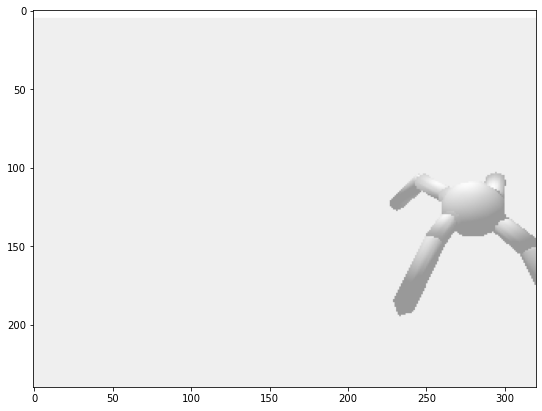

In [11]:
play_ant_render()